# Adaptive entanglement purification demo (IQuHack strategy)

This notebook mirrors the rung-based strategy described in `IQuHack (2).pdf`:
- Rung 0: edge characterization + basis adaptation (I x I, H x H, HS x HS)
- Rung 1: single-step DEJMPS recurrence
- Rung 2: order-adaptive two-step DEJMPS
- Rung 3: filtering for hard edges (low success, high fidelity)

Below we visualize the hierarchical recurrence circuits used in rungs 1-2:
N=2 (one round), N=4 (two levels), N=8 (three levels), plus a shifted-basis N=2 example.


## Setup

In [1]:
from qiskit import QuantumCircuit
from IPython.display import display
import matplotlib.pyplot as plt

# Higher DPI keeps large circuits readable.
plt.rcParams["figure.dpi"] = 140


## Circuit builders (basis adaptation + hierarchical DEJMPS)

In [2]:
def _pair_qubits(pair_idx: int):
    """Return (Alice, Bob) qubit indices for a Bell pair.

    Layout: (A0, B0, A1, B1, ..., A{N-1}, B{N-1})
    """
    return 2 * pair_idx, 2 * pair_idx + 1


def _apply_basis_shift(qc: QuantumCircuit, basis: str):
    """Apply the rung-0 basis adaptation to all qubits.

    basis = 'Z' -> I x I (no rotation)
    basis = 'X' -> H x H
    basis = 'Y' -> HS x HS
    """
    if basis == "Z":
        return
    if basis not in ("X", "Y"):
        raise ValueError("basis must be 'Z', 'X', or 'Y'")

    for q in range(qc.num_qubits):
        qc.h(q)
        if basis == "Y":
            qc.s(q)


def _distill_round(qc: QuantumCircuit, keep_idx: int, discard_idx: int, add_barriers: bool = True):
    """One DEJMPS-style recurrence step between two Bell pairs."""
    a_keep, b_keep = _pair_qubits(keep_idx)
    a_disc, b_disc = _pair_qubits(discard_idx)

    # Bilateral CNOT: keep -> discard
    qc.cx(a_keep, a_disc)
    qc.cx(b_keep, b_disc)

    # Measure the discard pair (parity check happens classically)
    qc.measure(a_disc, a_disc)
    qc.measure(b_disc, b_disc)

    if add_barriers:
        qc.barrier()


def create_hierarchical_dejmps_circuit(num_pairs: int, basis: str = "Z", add_barriers: bool = True):
    """Hierarchical DEJMPS ladder for N in {2,4,8}.

    N=2: 1 round
    N=4: 2 levels (0->1, 2->3, then 0->2)
    N=8: 3 levels (0->1,2->3,4->5,6->7 -> 0->2,4->6 -> 0->4)
    """
    if num_pairs not in (2, 4, 8):
        raise ValueError("num_pairs must be 2, 4, or 8")

    qc = QuantumCircuit(2 * num_pairs, 2 * num_pairs, name=f"N{num_pairs}-{basis}")

    _apply_basis_shift(qc, basis)
    if add_barriers and basis != "Z":
        qc.barrier()

    if num_pairs == 2:
        _distill_round(qc, 0, 1, add_barriers)
    elif num_pairs == 4:
        _distill_round(qc, 0, 1, add_barriers)
        _distill_round(qc, 2, 3, add_barriers)
        _distill_round(qc, 0, 2, add_barriers)
    elif num_pairs == 8:
        for keep, discard in [(0, 1), (2, 3), (4, 5), (6, 7)]:
            _distill_round(qc, keep, discard, add_barriers)
        for keep, discard in [(0, 2), (4, 6)]:
            _distill_round(qc, keep, discard, add_barriers)
        _distill_round(qc, 0, 4, add_barriers)

    return qc


## Hierarchical circuits (N=2, 4, 8)

Hierarchical DEJMPS circuit, N=2


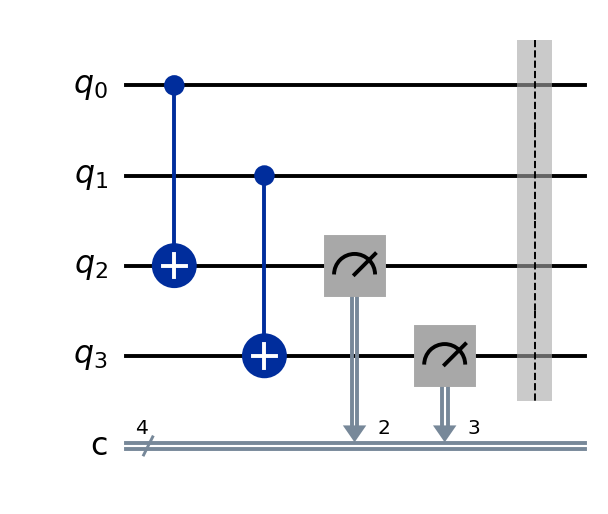

Hierarchical DEJMPS circuit, N=4


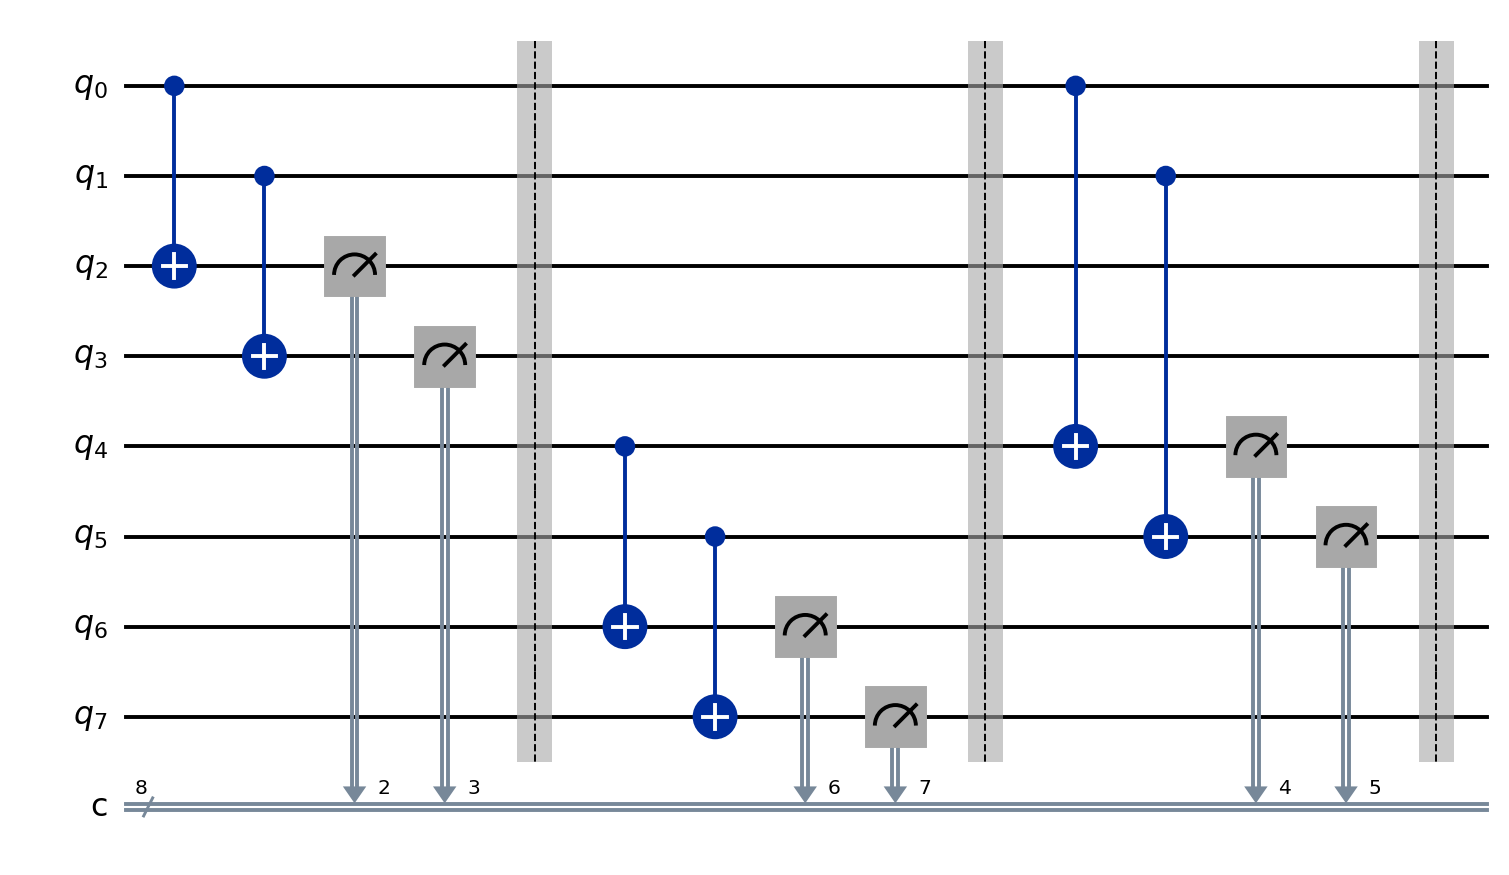

Hierarchical DEJMPS circuit, N=8


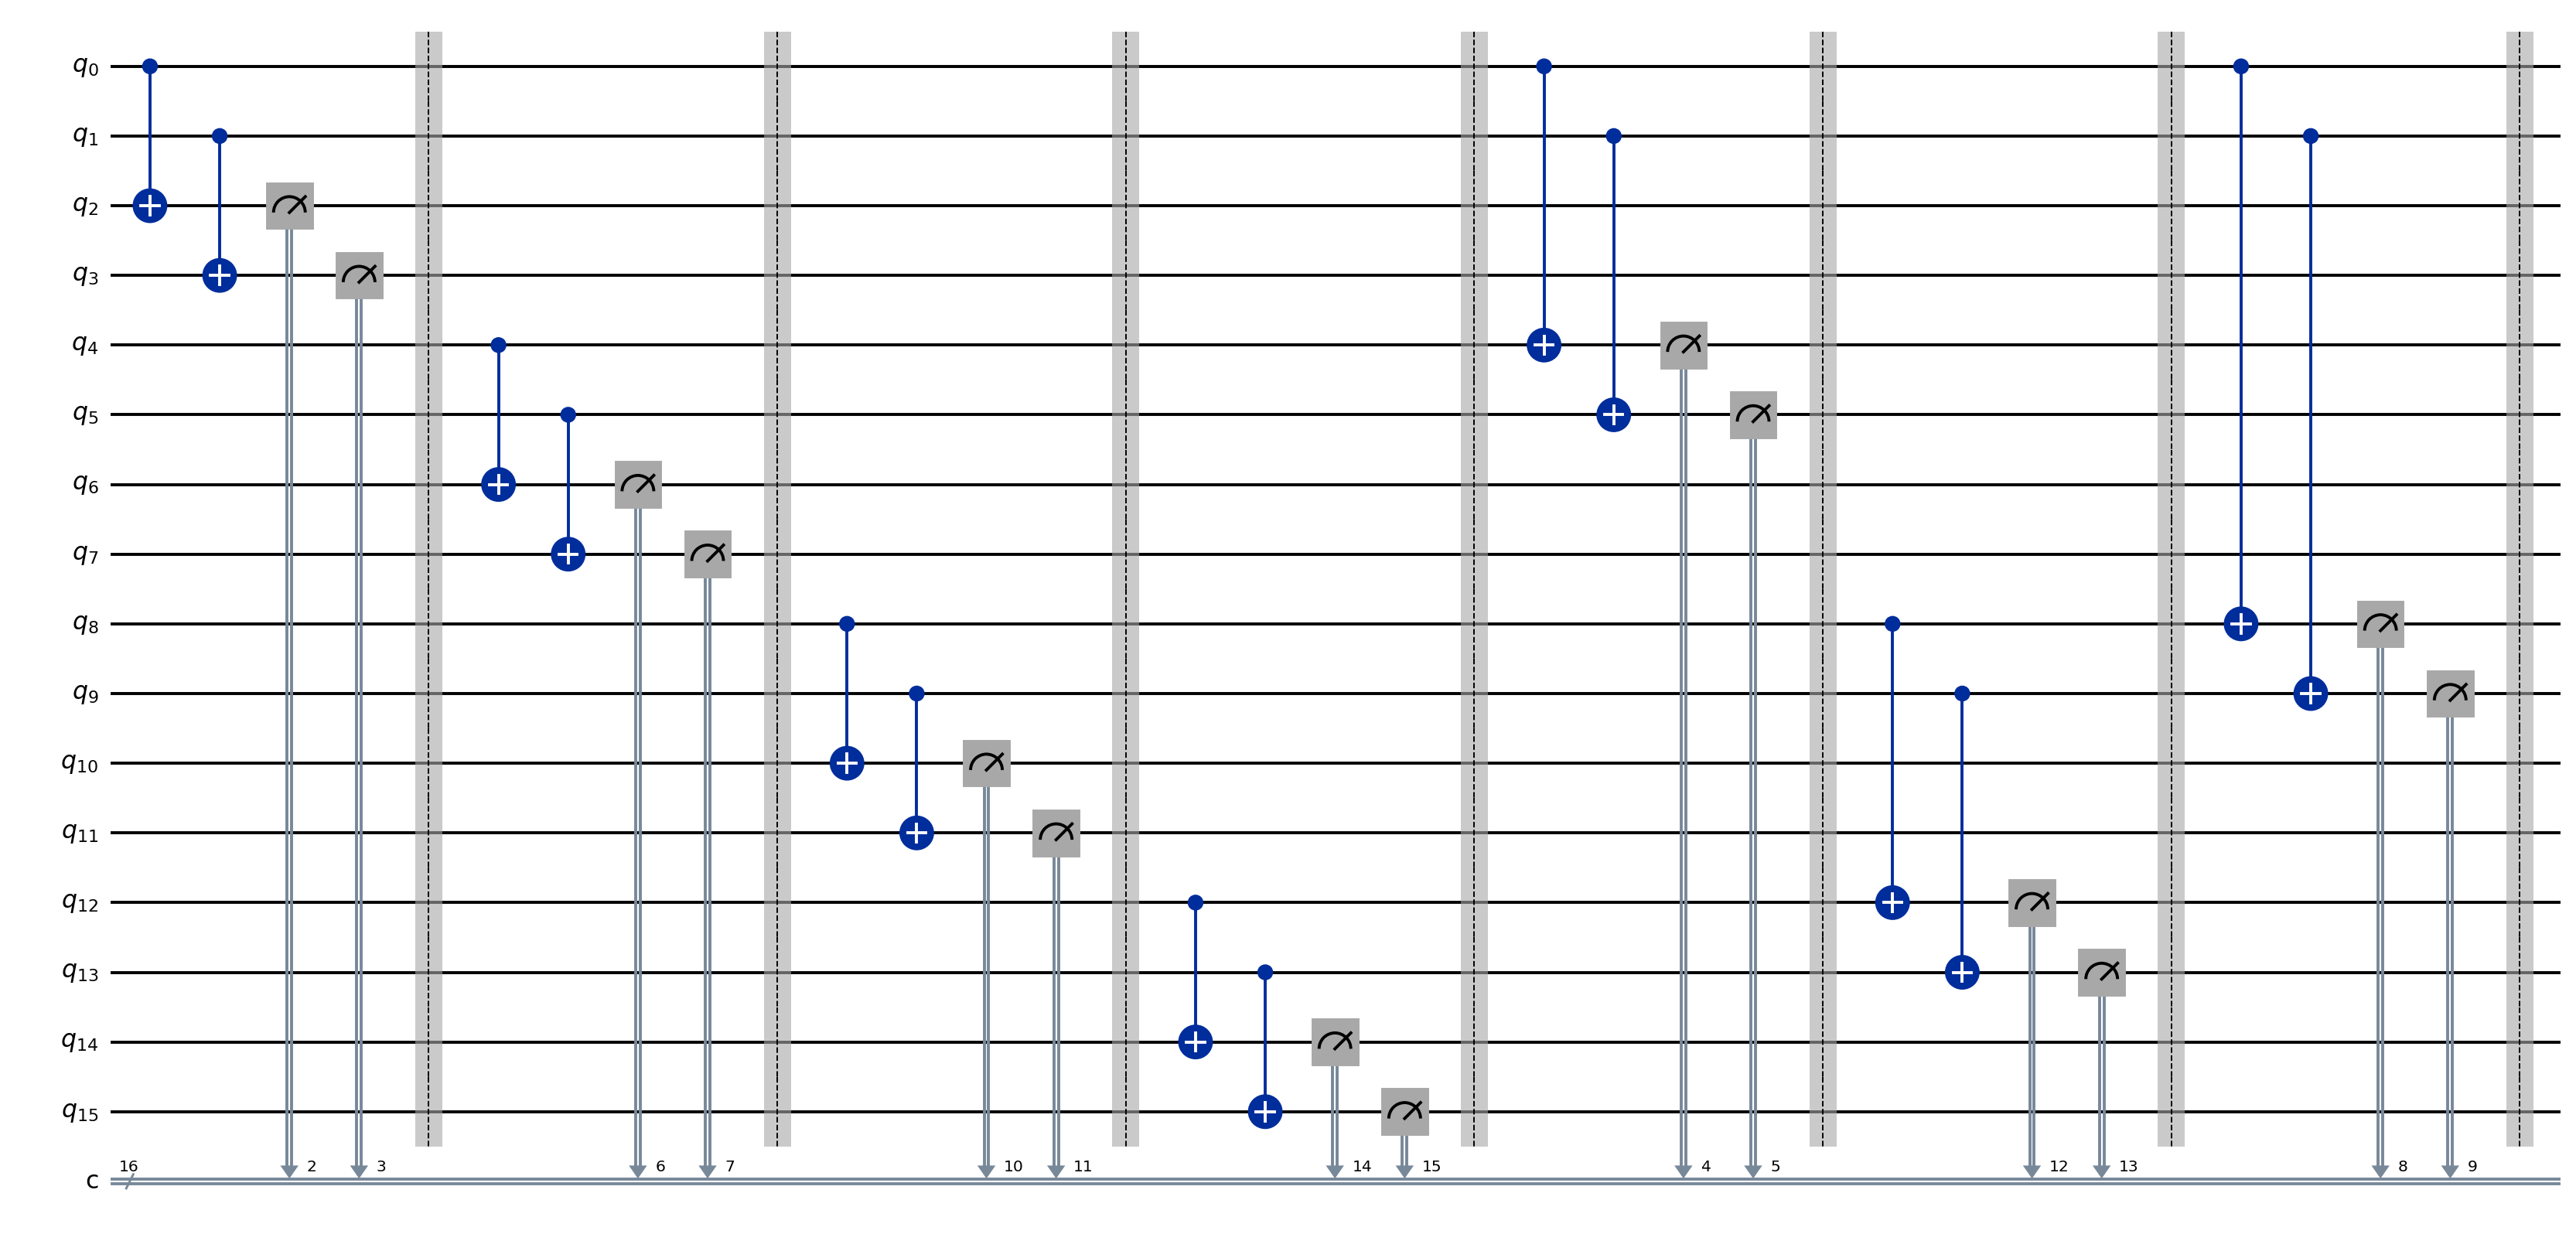

In [3]:
for N in (2, 4, 8):
    qc = create_hierarchical_dejmps_circuit(num_pairs=N, basis="Z")
    print(f"Hierarchical DEJMPS circuit, N={N}")
    display(qc.draw("mpl", fold=160))


## Shifted-basis example (N=2)

This uses the rung-0 basis adaptation for dominant Y noise (HS x HS).
Switch `basis="X"` if you want the H x H shift instead.


Shifted-basis DEJMPS circuit, N=2 (Y basis)


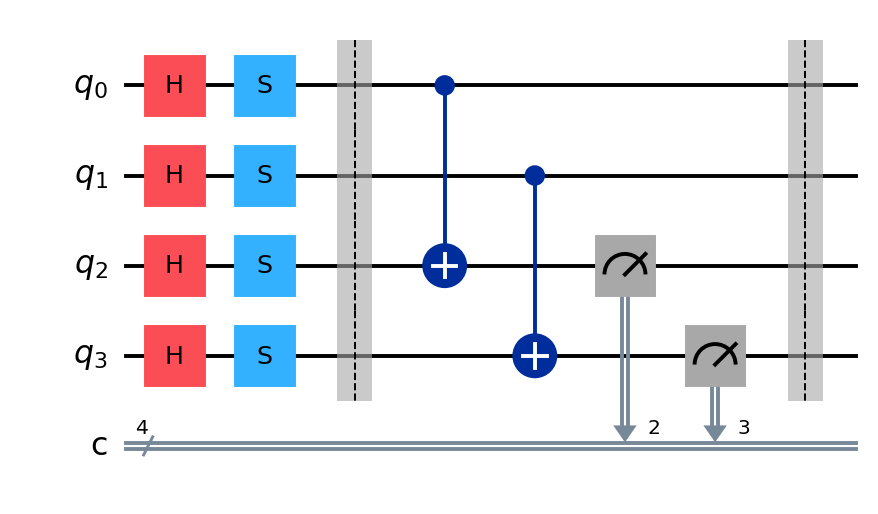

In [4]:
qc_shifted = create_hierarchical_dejmps_circuit(num_pairs=2, basis="Y")
print("Shifted-basis DEJMPS circuit, N=2 (Y basis)")
display(qc_shifted.draw("mpl", fold=160))
